# Regression model for classification?

## What is classification?

Just as in the simple regression setting, in the simple (univariate) classification setting, we have a set of training observations $ (x_1, y_1), \dots, (x_N, y_N) $, where each $ y_n $ is a qualitative (categorical) response.

In this chapter, we will illustrate the concept of classification using the simulated [Default dataset](https://github.com/pykale/transparentML/blob/main/data/Default.csv) (click to explore). We are interested in predicting whether an individual will default on his or her credit card payment, which takes on the value `Yes` if the customer defaults on their credit card payment and `No` if they do not, on the basis of annual income and monthly credit card balance.

Get ready by importing the APIs needed from respective libraries.

In [ ]:
import pandas as pd
import numpy as np
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from statsmodels.formula.api import logit

%matplotlib inline

Load the [Default dataset](https://github.com/pykale/transparentML/blob/main/data/Default.csv) as a pandas dataframe, convert categories (`default` and `student`) to numerical values (0 and 1), and inspect the first three rows.

In [ ]:
data_url = "https://github.com/pykale/transparentML/raw/main/data/Default.csv"
df = pd.read_csv(data_url)

# Note: factorize() returns two objects: a label array and an array with the unique values.
# We are only interested in the first object.
df["default2"] = df.default.factorize()[0]
df["student2"] = df.student.factorize()[0]
df.head(3)

It is a good habit to inspect the data in a bit more detail before fitting a model. Let us visualise 10,000 individuals' annual `income`, monthly credit card `balance`, and their relationships with the `default` status using [box plot](https://en.wikipedia.org/wiki/Box_plot).

In [ ]:
fig = plt.figure(figsize=(12, 5))
gs = GridSpec(1, 4)
ax1 = plt.subplot(gs[0, :-2])
ax2 = plt.subplot(gs[0, -2])
ax3 = plt.subplot(gs[0, -1])

# Take a fraction of the samples where target value (default) is 'no'
df_no = df[df.default2 == 0].sample(frac=0.15)
# Take all samples  where target value is 'yes'
df_yes = df[df.default2 == 1]
#
df_ = pd.concat((df_no, df_yes))

ax1.scatter(
    df_[df_.default == "Yes"].balance,
    df_[df_.default == "Yes"].income,
    s=40,
    c="orange",
    marker="+",
    linewidths=1,
)
ax1.scatter(
    df_[df_.default == "No"].balance,
    df_[df_.default == "No"].income,
    s=40,
    marker="o",
    linewidths=1,
    edgecolors="lightblue",
    facecolors="white",
    alpha=0.6,
)
#
ax1.set_ylim(ymin=0)
ax1.set_ylabel("Income")
ax1.set_xlim(xmin=-100)
ax1.set_xlabel("Balance")

c_palette = {"No": "lightblue", "Yes": "orange"}
sns.boxplot(data=df, y="balance", x="default", orient="v", ax=ax2, palette=c_palette)
sns.boxplot(data=df, y="income", x="default", orient="v", ax=ax3, palette=c_palette)
gs.tight_layout(plt.gcf())
# plt.show()

In the left-hand panel, the individuals who defaulted in a given month are shown in orange, and those who did not in blue. (The overall default rate is about 3\%, so we have plotted only a fraction of the individuals who did not default.) In the centre and right-hand panels, two pairs of boxplots are shown. The first shows the distribution of balance split by the binary default variable; the second is a similar plot for income. 

```{admonition} What can you observe from the visualisation above?
:class: tip, dropdown
From the left-hand panel, it appears that individuals who defaulted tended to have higher credit card balances than those who did not. 

From the centre and right-hand panels, it appears that individuals who defaulted tended to have higher balance than those who did not.

<!-- In this chapter, we learn how to build a model to predict default ($y$) for any given value of balance ($x_1$) and income ($x_2$). Since $y$ is not quantitative, the simple linear regression model of Chapter 3 is not a good choice: we will elaborate on this in the next section.  -->

```
It is worth noting that this example displays a very pronounced relationship between the predictor `balance` and the response `default`. In most real applications, the relationship between the predictor and the response will not be nearly so strong. To illustrate the classification procedures discussed, we use this example in which the relationship between the predictor and the response is somewhat exaggerated.

Can we use linear regression to predict the probability of default? 

## Can we use linear regression for classification?

<!-- There are two main reasons not to perform classification using a regression method: 

- A regression method cannot accommodate a qualitative response with more than two classes; 
- A regression method will not provide meaningful estimates of $\mathbb{P}(y|x)$ -->

### How about converting the response to a quantitative variable?

Since we can convert categorical variables (class labels) to numerical values, can we treat the classification problem as a regression problem and use linear regression to predict the class label?

Suppose there are three medical conditions of patients in an emergency room: `stroke`, `drug overdose`, and `epileptic seizure`. We could consider encoding these values as a quantitative response variable, $y$, as follows:

$$
y = \begin{cases} 1 & \text{if stroke}, \\ 2 & \text{if drug overdose}, \\ 3 & \text{if epileptic seizure}. \end{cases}
$$

Using this coding, least squares could be used to fit a linear regression model to predict $y$. However, this coding implies that `drug overdose` is a condition in between `stroke` and `epileptic seizure`, and insisting that the difference between stroke and drug overdose is the same as the difference between drug overdose and epileptic seizure . In practice, there is no particular reason that this needs to be the case. For instance, one could choose an equally reasonable coding,

$$
y = \begin{cases} 1 & \text{if epileptic seizure}, \\ 2 & \text{if stroke}, \\ 3 & \text{if drug overdose}, \end{cases}
$$

which would imply a totally different relationship among the three conditions. Each of these codings would produce fundamentally different linear models that would ultimately lead to different sets of predictions on test observations.

If the response variable’s values did take on a natural ordering, such as _mild, moderate, and severe_, and we felt the gap between mild and moderate was similar to the gap between moderate and severe, then a 1, 2, 3 coding would be reasonable. Even if so, unfortunately, in general there is no natural way to convert a qualitative response variable with more than two levels into a quantitative response that is ready for linear regression.

### Will the binary case work?

For a binary (two level) qualitative response, the situation is better. For example, perhaps there are only two possibilities for the patient’s medical condition: `stroke` and `drug overdose`. We could then code the response as
follows:

$$
y = \begin{cases} 1 & \text{if stroke}, \\ 0 & \text{if drug overdose}. \end{cases}
$$

We could then fit a linear regression to this binary response, and predict `drug overdose` if $ y > 0.5 $ and `stroke` otherwise. In the binary case, it is not hard to show that even if we flip the above coding, linear regression will produce the same final predictions.

Now let us compare the difference between the linear regression model and the logistic regression model for a binary classification task on the [Default dataset](https://github.com/pykale/transparentML/blob/main/data/Default.csv).

In [ ]:
X_train = df.balance.values.reshape(-1, 1)
y = df.default2

# Create array of test data. Calculate the classification probability and predicted classification.
X_test = np.arange(df.balance.min(), df.balance.max()).reshape(-1, 1)

clf = LogisticRegression(solver="newton-cg")
clf.fit(X_train, y)
prob = clf.predict_proba(X_test)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# Left plot
sns.regplot(
    x=df.balance,
    y=df.default2,
    order=1,
    ci=None,
    scatter_kws={"color": "orange"},
    line_kws={"color": "lightblue", "lw": 2},
    ax=ax1,
)
# Right plot
ax2.scatter(X_train, y, color="orange")
ax2.plot(X_test, prob[:, 1], color="lightblue")

for ax in fig.axes:
    ax.hlines(
        1,
        xmin=ax.xaxis.get_data_interval()[0],
        xmax=ax.xaxis.get_data_interval()[1],
        linestyles="dashed",
        lw=1,
    )
    ax.hlines(
        0,
        xmin=ax.xaxis.get_data_interval()[0],
        xmax=ax.xaxis.get_data_interval()[1],
        linestyles="dashed",
        lw=1,
    )
    ax.set_ylabel("Probability of default")
    ax.set_xlabel("Balance")
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
    ax.set_xlim(xmin=-100)

As shown in the output figure above, for a binary response with a 0/1 coding, although the linear regression model can also produce an estimate of $\mathbb{P}(y|x)$, some estimates might be outside the $[0, 1]$ interval, making them hard to be interpreted as probabilities. Since the predicted outcome of linear regression is not a probability, but a linear interpolation between points, there is no meaningful threshold at which you can distinguish one class from the other. 

An additional illustration of this issue is available on [Stackoverflow](https://stats.stackexchange.com/questions/22381/why-not-approach-classification-through-regression).

### Reasons not to perform classification using a regression method

There are two main reasons not to perform classification using a regression method:
- **Label coding**: Difficulty in coding the response variable with more than two classes;
- **Interpretation**: Difficulty in interpreting the predicted outcome of linear regression as a probability and thus in choosing a threshold to distinguish one class from the other.

## Exercise

1.There is no natural way to convert a qualitative response variable with more than two levels into a quantitative response that is ready for linear regression.

2. Linear regression can be used in probability prediction.


3. Difficulty in the response variable with more than two classes is high when we perform aclassification using a regression method.

4. All the follwoing exercises will use [Iris](https://github.com/pykale/transparentML/blob/main/data/Iris.csv) dataset.


a. Load the dataset and convert the categories to numerical values and inspact first 10 rows.

In [21]:
import pandas as pd
data_url = "https://github.com/pykale/transparentML/raw/main/data/Iris.csv"
df = pd.read_csv(data_url)
df["species1"] = df.species.factorize()[0]
df.head(10)

,sepal_length,sepal_width,petal_length,petal_width,species,species1
0,5.1,3.5,1.4,0.2,setosa,0
1,4.9,3.0,1.4,0.2,setosa,0
2,4.7,3.2,1.3,0.2,setosa,0
3,4.6,3.1,1.5,0.2,setosa,0
4,5.0,3.6,1.4,0.2,setosa,0
5,5.4,3.9,1.7,0.4,setosa,0
6,4.6,3.4,1.4,0.3,setosa,0
7,5.0,3.4,1.5,0.2,setosa,0
8,4.4,2.9,1.4,0.2,setosa,0
9,4.9,3.1,1.5,0.1,setosa,0


b. Visualise the the relationships of sepal length and width with the spiecies using box plot.

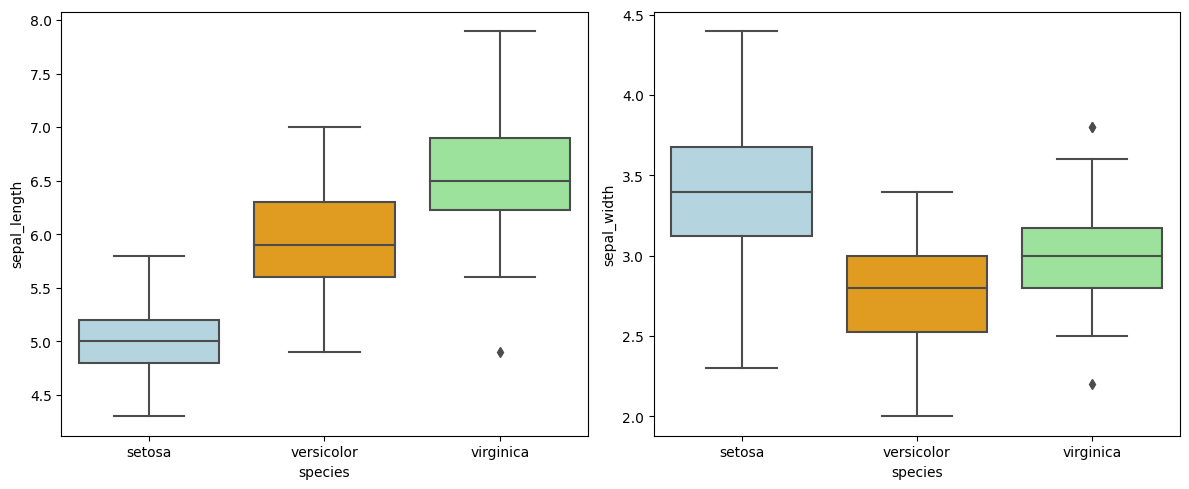

In [67]:
fig = plt.figure(figsize=(12, 5))
gs = GridSpec(1, 2)
ax2 = plt.subplot(gs[0, -2])
ax3 = plt.subplot(gs[0, -1])


c_palette = {"setosa": "lightblue", "versicolor": "orange","virginica": "lightgreen"}
sns.boxplot(data=df, y="sepal_length", x="species", orient="v", ax=ax2, palette=c_palette)
sns.boxplot(data=df, y="sepal_width", x="species", orient="v", ax=ax3, palette=c_palette)
gs.tight_layout(plt.gcf())
# plt.show()

5. 

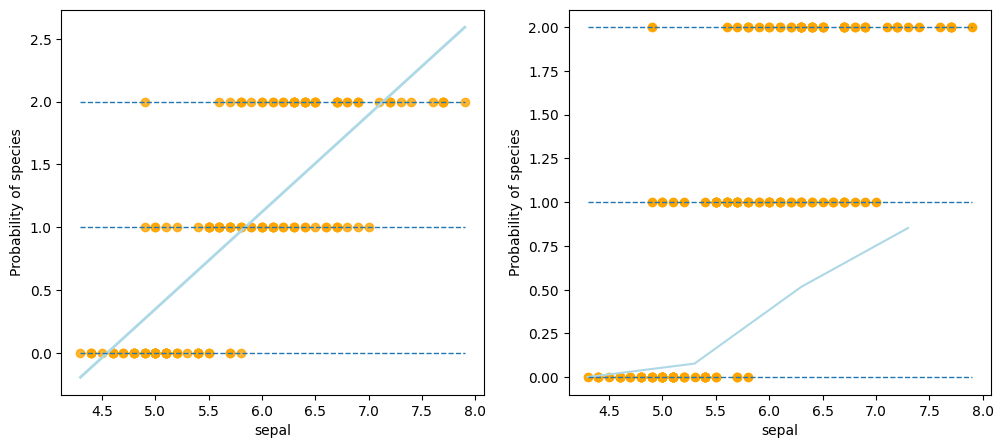

In [106]:
X_train = df.sepal_length.values.reshape(-1, 1)
y = df.species1

# Create array of test data. Calculate the classification probability and predicted classification.
X_test = np.arange(df.sepal_length.min(), df.sepal_length.max()).reshape(-1, 1)

clf = LogisticRegression(solver="newton-cg")
clf.fit(X_train, y)
prob = clf.predict_proba(X_test)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# Left plot
sns.regplot(
    x=df.sepal_length,
    y=df.species1,
    order=1,
    ci=None,
    scatter_kws={"color": "orange"},
    line_kws={"color": "lightblue", "lw": 2},
    ax=ax1,
)

# Right plot
ax2.scatter(X_train, y, color="orange")
ax2.plot(X_test, prob[:, 2], color="lightblue")

for ax in fig.axes:
    ax.hlines(
        2,
        xmin=ax.xaxis.get_data_interval()[0],
        xmax=ax.xaxis.get_data_interval()[1],
        linestyles="dashed",
        lw=1,
    )
    ax.hlines(
        1,
        xmin=ax.xaxis.get_data_interval()[0],
        xmax=ax.xaxis.get_data_interval()[1],
        linestyles="dashed",
        lw=1,
    )
    ax.hlines(
        0,
        xmin=ax.xaxis.get_data_interval()[0],
        xmax=ax.xaxis.get_data_interval()[1],
        linestyles="dashed",
        lw=1,
    )
    ax.set_ylabel("Probability of species")
    ax.set_xlabel("sepal")
